In [4]:
import experiment_utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nds import ndomsort
import pygmo as pg
from sklearn.model_selection import train_test_split
import random
import math

from moopt import monise
from fair_models import FairScalarization, EqualScalarization
from fair_models import SimpleVoting

import copy
import pickle

In [5]:
#data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
#fair_feature = "not_white"
#pred_feature = "Two_yr_Recidivism"
dataset = 'compas'
fair_feature = 'race'

In [6]:
X_train = pd.read_pickle("data/"+dataset+"_"+fair_feature+"/X_train.pickle")
with open("data/"+dataset+"_"+fair_feature+"/y_train.pickle", 'rb') as f:
    y_train = pickle.load(f)

X_val = pd.read_pickle("data/"+dataset+"_"+fair_feature+"/X_valid.pickle")
with open("data/"+dataset+"_"+fair_feature+"/y_valid.pickle", 'rb') as f:
    y_val = pickle.load(f)

X_test = pd.read_pickle("data/"+dataset+"_"+fair_feature+"/X_test.pickle")
with open("data/"+dataset+"_"+fair_feature+"/y_test.pickle", 'rb') as f:
    y_test = pickle.load(f)

In [7]:
def nds_moo(models_df, n_selected = 10, with_acc = False):
    models_df['EO'] = -models_df['EO']
    models_df['DP'] = -models_df['DP']
    if 'Acc' in models_df.columns:
        models_df['Acc'] = -models_df['Acc']
    metrics = models_df.values.tolist()

    fronts = ndomsort.non_domin_sort(metrics)
    selected_indexes = []
    for front in fronts:
        hv = pg.hypervolume([list(s) for s in fronts[front]])
        
        if len(selected_indexes)==n_selected:
            break
        
        if len(fronts[front])+len(selected_indexes)<n_selected:
            selected_indexes+=[metrics.index(seq) for seq in fronts[front]]
        else:
            last_front = list(copy.copy(fronts[front]))
            
            nadir = np.max(metrics,axis=0)
            nadir = nadir
            while len(last_front)>n_selected-len(selected_indexes):
                hv = pg.hypervolume([list(s) for s in last_front])
                idx_excl = hv.least_contributor(nadir)
                del last_front[idx_excl]
                
            selected_indexes += [metrics.index(seq) for seq in last_front]
            
    index_list = [models_df.index.tolist()[i] for i in selected_indexes]
    return index_list


def ensemble_from_filtered_models(filtered_models, fair_feature, X_test, y_test):
    # Generate ensemble
    ensemble_model = SimpleVoting(estimators=filtered_models, voting='soft')
    # Evaluate
    metrics = experiment_utils.evaluate_model_test(ensemble_model, fair_feature, X_test, y_test)
    return metrics

def simple_filter(models_df, n_acc, fair_metric, fair_filter):
    if fair_filter:
        n_fair = 10
        if fair_metric == 'CV':
            index_list = list(models_df.nlargest(n_acc,'Acc').nsmallest(n_fair,fair_metric).index)
        else:
            index_list = list(models_df.nlargest(n_acc,'Acc').nlargest(n_fair,fair_metric).index)
    else:
        index_list = list(models_df.nlargest(n_acc,'Acc').index)
    return index_list

def nds_filter(models_df, n_acc, with_acc):
    models_acc = models_df.nlargest(n_acc,'Acc')
    if not with_acc:
        models_acc = models_acc.drop(['Acc'], axis=1)
    index_list = nds_moo(models_acc, with_acc = with_acc)
    return index_list


def ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc, fair_metric = 'DP', fair_filter = True,
                    nds = False, with_acc = True):
    if nds:
        index_list = nds_filter(models_df, n_acc, with_acc)
    else:
        index_list = simple_filter(models_df, n_acc, fair_metric, fair_filter)
    
    filtered_models = [("Model "+str(i), models_sols[i]) for i in index_list]
    metrics = ensemble_from_filtered_models(filtered_models, fair_feature, X_test, y_test)
    
    if nds:
        if n_acc==150:
            metrics['Filter'] = 'NDS(wAcc)' if with_acc else 'NDS'
        else:
            metrics['Filter'] = str(n_acc)+'Acc+NDS(wAcc)' if with_acc else str(n_acc)+'Acc+NDS'
    else:
        if fair_filter:
            metrics['Filter'] = str(n_acc)+'Acc+'+fair_metric
        else:
            metrics['Filter'] = 'All models' if n_acc==150 else str(n_acc)+'Acc'

    return metrics

def compare_ensembles_fair_metrics(models_df, models_sols, fair_feature, X_test, y_test):
    ensembles_metrics = [
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 150, fair_filter = False),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 50, fair_filter = True, fair_metric='DP'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, fair_filter = True, fair_metric='DP'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 50, fair_filter = True, fair_metric='EO'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, fair_filter = True, fair_metric='EO'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 50, fair_filter = True, fair_metric='CV'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, fair_filter = True, fair_metric='CV')
    ]
    results_test = pd.DataFrame(ensembles_metrics)
    results_test = results_test.set_index('Filter')
    return results_test.copy()

def compare_ensembles_nds(models_df, models_sols, fair_feature, X_test, y_test):
    ensembles_metrics = [
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 150, fair_filter = False),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 50, fair_filter = True, fair_metric='DP'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, fair_filter = True, fair_metric='DP'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 150, nds = True, with_acc=True),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 50, nds = True, with_acc=True),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, nds = True, with_acc=True),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 150, nds = True, with_acc=False),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 50, nds = True, with_acc=False),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, nds = True, with_acc=False)
    ]
    results_test = pd.DataFrame(ensembles_metrics)
    results_test = results_test.set_index('Filter')
    return results_test.copy()

# MOOError

In [8]:
## Train 150 models
moo_err = monise(weightedScalar=FairScalarization(X_train, y_train, fair_feature),
                singleScalar=FairScalarization(X_train, y_train, fair_feature),
                nodeTimeLimit=2, targetSize=150,
                targetGap=0, nodeGap=0.05, norm=False)

moo_err.optimize()

## Evaluate the models in val
mooerr_values = []
mooerr_sols = []

for solution in moo_err.solutionsList:
    mooerr_sols.append(solution.x)
    mooerr_values.append(experiment_utils.evaluate_model_test(solution.x, fair_feature, X_val, y_val))

mooerr_df = pd.DataFrame(mooerr_values)

2021-08-19 10:56:57,442 - moopt.monise - DEBUG: Finding 1th individual minima
2021-08-19 10:56:57,492 - moopt.monise - DEBUG: Finding 2th individual minima
2021-08-19 10:56:57,559 - moopt.monise - DEBUG: Finding 3th individual minima


Academic license - for non-commercial use only - expires 2021-10-17
Using license file /home/viguardieiro/gurobi.lic


2021-08-19 10:56:57,672 - moopt.monise - DEBUG: 4th solution - importance: 1.0
2021-08-19 10:56:57,731 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-08-19 10:56:57,826 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-08-19 10:56:57,912 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-08-19 10:56:58,042 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-08-19 10:56:58,201 - moopt.monise - DEBUG: 9th solution - importance: 0.7988211334396822
2021-08-19 10:56:58,369 - moopt.monise - DEBUG: 10th solution - importance: 0.40494742894494073
2021-08-19 10:56:58,534 - moopt.monise - DEBUG: 11th solution - importance: 0.3943057454005531
2021-08-19 10:56:58,681 - moopt.monise - DEBUG: 12th solution - importance: 0.20410364844362613
2021-08-19 10:56:58,806 - moopt.monise - DEBUG: 13th solution - importance: 0.20348262095227188
2021-08-19 10:56:58,994 - moopt.monise - DEBUG: 14th solution - importance: 0.1730559416923613
2021-08-19 10:56:59,145 - moopt.m

In [ ]:
err_fair_results = compare_ensembles_fair_metrics(mooerr_df, mooerr_sols, fair_feature, X_test, y_test)
err_nds_results = compare_ensembles_nds(mooerr_df, mooerr_sols, fair_feature, X_test, y_test)

In [ ]:
## Train 150 models
mooacep = monise(weightedScalar=EqualScalarization(X_train, y_train, fair_feature),
            singleScalar=EqualScalarization(X_train, y_train, fair_feature),
            nodeTimeLimit=2, targetSize=150,
            targetGap=0, nodeGap=0.01, norm=False)

mooacep.optimize()

## Evaluate the models in val
mooacc_values = []
mooacc_sols = []

for solution in mooacep.solutionsList:
    mooacc_sols.append(solution.x)
    mooacc_values.append(experiment_utils.evaluate_model_test(solution.x, fair_feature, X_val, y_val))

mooacep_df = pd.DataFrame(mooacc_values)

2021-08-19 10:33:45,034 - moopt.monise - DEBUG: Finding 1th individual minima
2021-08-19 10:33:45,127 - moopt.monise - DEBUG: Finding 2th individual minima
2021-08-19 10:33:45,280 - moopt.monise - DEBUG: Finding 3th individual minima
2021-08-19 10:33:45,436 - moopt.monise - DEBUG: Finding 4th individual minima
2021-08-19 10:33:45,624 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-08-19 10:33:45,772 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-08-19 10:33:45,925 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-08-19 10:33:46,084 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-08-19 10:33:46,256 - moopt.monise - DEBUG: 9th solution - importance: 1.0
2021-08-19 10:33:46,451 - moopt.monise - DEBUG: 10th solution - importance: 0.6307643494781998
2021-08-19 10:33:46,623 - moopt.monise - DEBUG: 11th solution - importance: 0.49635107719875093
2021-08-19 10:33:46,794 - moopt.monise - DEBUG: 12th solution - importance: 0.3597108193047771
2021-08

In [ ]:
acep_fair_results = compare_ensembles_fair_metrics(mooacep_df, mooacc_sols, fair_feature, X_test, y_test)
acep_nds_results = compare_ensembles_nds(mooacep_df, mooacc_sols, fair_feature, X_test, y_test)

# Vis

In [ ]:
def vis_comp(err_results, acep_results):
    fig, axs = plt.subplots(nrows=2, ncols=4, constrained_layout=True, figsize=(15,6), sharex=True)

    # MOOErr
    err_results['Acc'].plot.bar(ax=axs[0,0], zorder=3)
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_ylabel('MOOErr', fontsize=12)
    high_acc = max(err_results['Acc'].max(), acep_results['Acc'].max())
    low_acc = min(err_results['Acc'].min(), acep_results['Acc'].min())
    axs[0, 0].set_ylim([low_acc-0.25*(high_acc-low_acc), high_acc+0.25*(high_acc-low_acc)])

    err_results['DP'].plot.bar(ax=axs[0,1], zorder=3)
    axs[0, 1].set_title('Demographic Parity')
    high_dp = max(err_results['DP'].max(), acep_results['DP'].max())
    low_dp = min(err_results['DP'].min(), acep_results['DP'].min())
    axs[0, 1].set_ylim([low_dp-0.25*(high_dp-low_dp), high_dp+0.25*(high_dp-low_dp)])

    err_results['EO'].plot.bar(ax=axs[0,2], zorder=3)
    axs[0, 2].set_title('Equal Oportunity')
    high_eo = max(err_results['EO'].max(), acep_results['EO'].max())
    low_eo = min(err_results['EO'].min(), acep_results['EO'].min())
    axs[0, 2].set_ylim([low_eo-0.25*(high_eo-low_eo), high_eo+0.25*(high_eo-low_eo)])

    err_results['CV'].plot.bar(ax=axs[0,3], zorder=3)
    axs[0, 3].set_title('Coeficient of Variation')
    high_cv = max(err_results['CV'].max(), acep_results['CV'].max())
    low_cv = min(err_results['CV'].min(), acep_results['CV'].min())
    axs[0, 3].set_ylim([low_cv-0.25*(high_cv-low_cv), high_cv+0.25*(high_cv-low_cv)])

    # MOOAcep
    acep_results['Acc'].plot.bar(ax=axs[1,0], color='red', zorder=3)
    axs[1, 0].set_xlabel('Filter')
    axs[1, 0].set_xticklabels(acep_results.index, rotation=45, ha="right", rotation_mode="anchor")
    axs[1, 0].set_ylabel('MOOAcep', fontsize=12)
    axs[1, 0].set_ylim([low_acc-0.25*(high_acc-low_acc), high_acc+0.25*(high_acc-low_acc)])

    acep_results['DP'].plot.bar(ax=axs[1,1], color='red', zorder=3)
    axs[1, 1].set_xticklabels(acep_results.index, rotation=45, ha="right", rotation_mode="anchor")
    axs[1, 1].set_xlabel('Filter')
    axs[1, 1].set_ylim([low_dp-0.25*(high_dp-low_dp), high_dp+0.25*(high_dp-low_dp)])

    acep_results['EO'].plot.bar(ax=axs[1,2], color='r', zorder=3)
    axs[1, 2].set_xlabel('Filter')
    axs[1, 2].set_xticklabels(acep_results.index, rotation=45, ha="right", rotation_mode="anchor")
    axs[1, 2].set_ylim([low_eo-0.25*(high_eo-low_eo), high_eo+0.25*(high_eo-low_eo)])

    acep_results['CV'].plot.bar(ax=axs[1,3], color='r', zorder=3)
    axs[1, 3].set_xlabel('Filter')
    axs[1, 3].set_xticklabels(acep_results.index, rotation=45, ha="right", rotation_mode="anchor")
    axs[1, 3].set_ylim([low_cv-0.25*(high_cv-low_cv), high_cv+0.25*(high_cv-low_cv)])

    for ax in axs.flatten():
        #ax.xaxis.set_tick_params(labelbottom=True)
        ax.yaxis.set_tick_params(labelleft=True)
        ax.grid(axis='y', color='gray', linestyle='dotted')

    #plt.show()
    return fig, axs

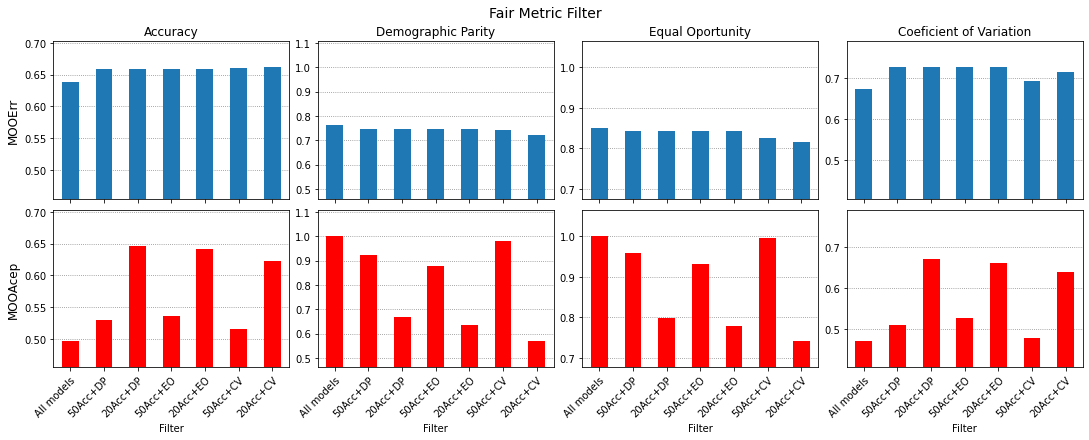

In [ ]:
fig, axs = vis_comp(err_fair_results, acep_fair_results)
fig.suptitle('Fair Metric Filter', size=14)
plt.show()

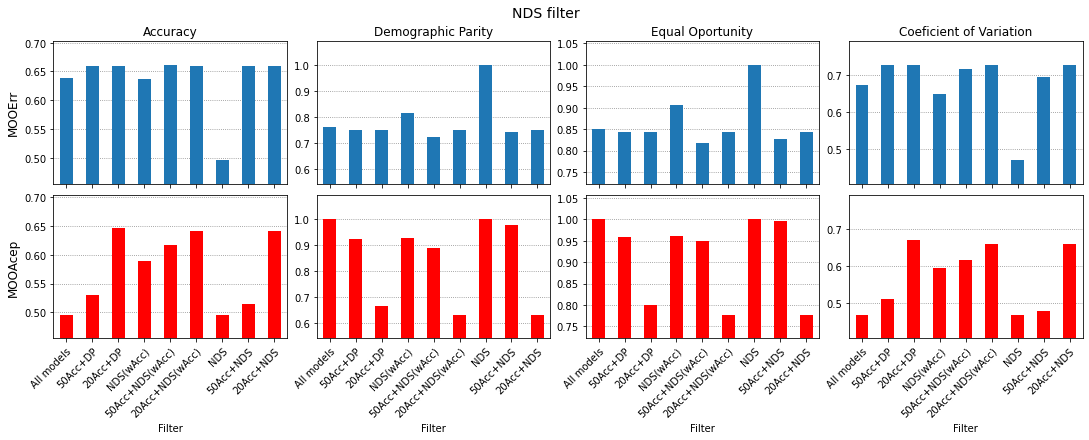

In [ ]:
fig, axs = vis_comp(err_nds_results, acep_nds_results)
fig.suptitle('NDS filter', size=14)
plt.show()

In [ ]:
err_nds_results

,Acc,EO,DP,CV
Filter,,,,
All models,0.638889,0.850315,0.761017,0.673215
50Acc+DP,0.659091,0.842496,0.748045,0.727287
20Acc+DP,0.659091,0.842496,0.748045,0.727287
NDS(wAcc),0.637626,0.905530,0.816125,0.648586
50Acc+NDS(wAcc),0.661616,0.817119,0.722795,0.715320
20Acc+NDS(wAcc),0.659091,0.842496,0.748045,0.727287
NDS,0.496212,1.000000,1.000000,0.470204
50Acc+NDS,0.660354,0.825988,0.741028,0.694655
20Acc+NDS,0.659091,0.842496,0.748045,0.727287


In [ ]:
acep_nds_results

,Acc,EO,DP,CV
Filter,,,,
All models,0.496212,1.000000,1.000000,0.470204
50Acc+DP,0.530303,0.957891,0.923898,0.510777
20Acc+DP,0.646465,0.799598,0.666980,0.672583
NDS(wAcc),0.588384,0.960590,0.929805,0.595006
50Acc+NDS(wAcc),0.617424,0.949765,0.890644,0.618169
20Acc+NDS(wAcc),0.641414,0.777751,0.634331,0.660767
NDS,0.496212,1.000000,1.000000,0.470204
50Acc+NDS,0.515152,0.995025,0.979614,0.479133
20Acc+NDS,0.641414,0.777751,0.634331,0.660767
